## **3D PLOT FOM-ROM @ FINAL TIME and for $\boldsymbol{\mu}_{reference}$**

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import load_npz
import h5py
import sys
import os

# Import user-defined libraries:
sys.path.append(os.path.abspath('/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/fit White/0. full order'))
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4711/2141601097.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_4711/2141601097.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [ ]:
# Load coordinates:
data_path = os.path.abspath('/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/fit White/0. full order/mesh_utilities')
coordinates_Px = FFvector_fread(os.path.join(data_path, 'vv_cc_Px.btxt'))
coordinates_Pq = FFvector_fread(os.path.join(data_path, 'vv_cc_Pq.btxt'))

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([np.linalg.norm(coordinates_Px[ii, :2]) for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_mid_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]


mass_Px = FFmatrix_fread(os.path.join(data_path, 'ww_mm_Px.btxt'))
volume = mass_Px.dot(np.ones(sFO_Px)).dot(np.ones(sFO_Px))
inte_C = mass_Px.dot(np.ones((sFO_Px))) / volume                   #ho tolto [mask_in_C]

### FOM SOLUTION

In [11]:
sol_new_C = np.loadtxt('../0. full order/data/Concentration_field.csv', delimiter=',')
print(mass_Px.dot(sol_new_C[:, -1]).dot(np.ones((sFO_Px, 1)))[0] / volume)
print(inte_C @ sol_new_C[:,1000])

4.510621327059395e+24
4.5106213270593804e+24


### ROM SOLUTION

In [48]:
# Apri il file in modalità lettura
with h5py.File('../2. DEIM-POD/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]
    FF_RB = hf['FF_RB'][:]
    KK_RB = hf['KK_RB'][:]
    AA_RB = hf['AA_RB'][:]
    ZZ_CO = hf['ZZ_CO'][:]
    II_CO = hf['II_CO'][:]
    basis = hf['basis'][:]

xz_y = load_npz('../0. full order/mesh_utilities/xz_y_0.npz')
xy_z = load_npz('../0. full order/mesh_utilities/xz_y_0.npz')

n_dofs = coordinates_Px.shape[0]
n_cols = basis.shape[1]
basis_extended = np.zeros((n_dofs, n_cols))
basis_extended[mask_in_C, :] = basis
print(basis_extended.shape)

reconstructed = np.loadtxt('data/Reconstructed_field_reference.csv', delimiter=',')

(119763, 57)


In [13]:
# Define universal constants:
FISSION_ENERGY = 3.215E-11                      #[J/fissions]

# Define geometrical parameters:
RADIUS = 1e-05
LENGTH = 1e-03

# Define sources intensity:
FISSION_RATE = 3e19
FISSION_YIELD = 0.24E+00                
FUEL_THERMAL_CONDUCTIVITY = 2.208                                      #[W/(m K)]
SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

T_BC = 2000

TIME_DELTA = 10000

In [14]:
TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

#SCIANTIX userà il modello scelto dall'utente 
WW = 2.949513e-13 * np.exp(-20487.36244 / (TT));
 
CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))
 
SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB
 
LHS_RB_static = MM_RB + TIME_DELTA * SS_RB #matrice + matrice * scalare. Avendo il termine MM_RB al lhs è forward euler, se invece fosse nel RHS sarebbe Backward. 
RHS_RB_static = TIME_DELTA * QQ_RB         #vettore per scalare

In [47]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1000))
for ii in range(1000):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])

reconstructed_field = np.dot(basis_extended, old_sol_RB[:,0])
print(reconstructed_field.shape)
np.savetxt('data/Reconstructed_field_reference.csv', reconstructed_field, delimiter=',', fmt='%d')

6.5401608302233205e+22
1.2768469559737866e+23
1.876501724900377e+23
2.457077899846546e+23
3.0211515013651166e+23
3.570531206330321e+23
4.106576089138546e+23
4.6303558233113135e+23
5.1427410022609675e+23
5.644458296098036e+23
6.136126289269918e+23
6.618279937026235e+23
7.091387919124261e+23
7.55586534590893e+23
8.012083303675983e+23
8.46037618163656e+23
8.90104740054936e+23
9.334373963942052e+23
9.760610125213688e+23
1.0179990379582954e+24
1.0592731932679273e+24
1.0999036757950698e+24
1.1399093327065515e+24
1.1793078077356957e+24
1.218115666566728e+24
1.2563485047067808e+24
1.294021040877237e+24
1.331147198336892e+24
1.367740176074258e+24
1.4038125114380247e+24
1.439376135486418e+24
1.474442422108637e+24
1.5090222317903453e+24
1.5431259507498268e+24
1.5767635260539056e+24
1.609944497227118e+24
1.6426780247892933e+24
1.6749729160921774e+24
1.7068376487722283e+24
1.7382803920921853e+24
1.76930902640666e+24
1.7999311609556307e+24
1.8301541501631774e+24
1.8599851085962667e+24
1.889430924719

In [49]:
FOM = xz_y @ sol_new_C[:, -1]
ROM = xz_y @ reconstructed_field 

FOM_ROM = np.abs(FOM - ROM)
print(np.max(FOM_ROM))
print(FOM_ROM.shape)

FOM_ROM = np.abs(FOM - ROM)/np.max(np.abs(FOM))
print(np.max(FOM_ROM))

1.8205479614077215e+22
(10000,)
0.0010568795810172128


In [ ]:
ABS_ERR = np.linalg.norm(FOM - ROM[:,0], axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(sol_new_C[:, -1], axis=0)
print(REL_ERR)

0.00033101863593238876


In [ ]:
#FOM_ROM = np.abs(sol_new_C[:, -1] - ROM[:,0])
#/sol_new_C[mask_in_C, -1])*100

#FOM-ROM = np.abs(sol_new_C[:, -1] - ROM[:,0]) / np.max(np.abs(sol_new_C[:,-1]))

#FOM_ROM = np.abs(sol_new_C[:, -1] - ROM[:,0])/sol_new_C[:, -1]
#print(np.max(FOM_ROM))
#print(FOM_ROM.shape)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

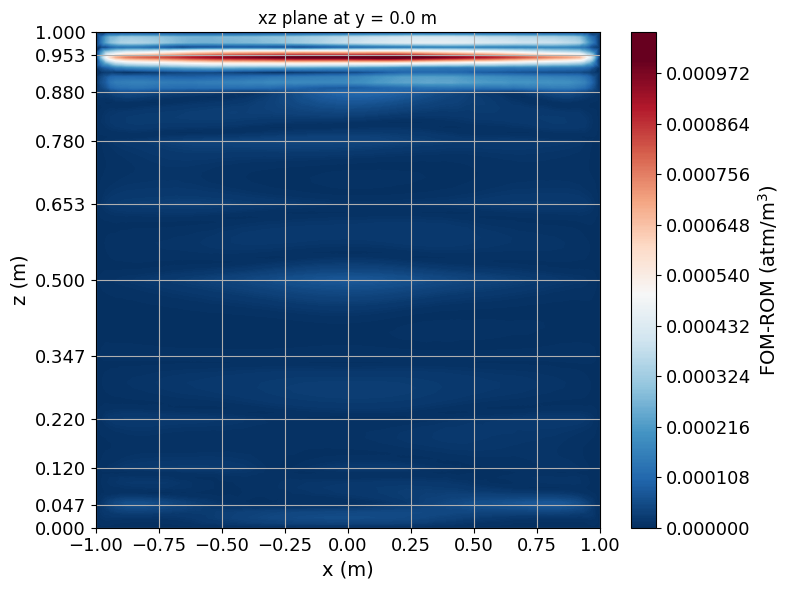

In [45]:
PP = 99  
x_coords_at_y = np.empty(((PP+1)*(PP+1)))
z_coords_at_y = np.empty(((PP+1)*(PP+1)))
for ii in range(PP+1):
    for jj in range(PP+1):
        index = (PP+1)*ii + jj
        x_coords_at_y[index] = 2 * (ii / PP) - 1  
        z_coords_at_y[index] = jj / PP  

# Converti in array NumPy
x_coords_at_y = np.array(x_coords_at_y)
z_coords_at_y = np.array(z_coords_at_y)

total_layers = list(set(coordinates_Px[:,2]))
effective_layers = sorted(list(set(coordinates_Px[:,2])))[::2]

concentration_at_y = FOM_ROM
plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_coords_at_y, z_coords_at_y, concentration_at_y, 400, cmap='RdBu_r', vmin=0, vmax = 0.001)
cbar = plt.colorbar(contour)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('FOM-ROM (atm/m$^3$)', fontsize=14)

plt.title(f'xz plane at y = {0.00} m')
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlim([-1, 1])
plt.yticks(effective_layers)
plt.xlabel('x (m)',fontsize=14)
plt.ylabel('z (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('FOM_xz_brutal.pdf', bbox_inches='tight') 